In [6]:
import copy
import torch

from models.gmrf.common.obstacle_map import ObstacleMap
from models.gmrf.common.observation import Observation
from models.gmrf.gmrf.gmrf_gas.gmrf_gas import GMRF_Gas, GMRF_Gas_Efficient


class myGMRF():
    def __init__(self, sigma_gz=None, sigma_gr=None, sigma_gb=None, gtk=None, resolution=None):
        om = ObstacleMap(dimensions=2, size=(25,30), resolution=resolution) 
        self.g = GMRF_Gas(om, 
                          sigma_gz=sigma_gz,
                          sigma_gr=sigma_gr,
                          sigma_gb=sigma_gb,
                          gtk=gtk,
                          resolution=resolution)
        
#    def calculate_old(self, y):
#        """ Calculates the distribution with GMRF. Takes true distribution as input, but grabs the positions of the sparse sensor network.
#        Must be adapted, if different sampling positions are desired."""
#        g_c = copy.deepcopy(self.g)
        
#        n = 5
#        for row in range(int(n/2), 30, n): 
#            for col in range(int(n/2), 25, n):
#                conc = y[row][col]
#                obs = Observation(position=((col,30-row)), gas=conc) # adjust the y axis
#                g_c.addObservation(obs)
#        g_c.estimate()
#        return torch.tensor(g_c.getGasEstimate()._data)
    
    def calculate(self, X):
        """ Calculates the distribution with GMRF. Must be adapted, if different sampling positions are desired."""
        g_c = copy.deepcopy(self.g)
        
        for row in range(6): 
            for col in range(5):
                conc = X[row][col]
                x_pos = col*5 + 2
                y_pos = (6-row)*5 - 2
                
                obs = Observation(position=(x_pos,y_pos), gas=conc) # adjust the y axis
                g_c.addObservation(obs)
        g_c.estimate()
        return torch.tensor(g_c.getGasEstimate()._data)

In [7]:
#import torch

# ~~~~~~~~~~~~~~~~
# GMRF

#from models.gmrf.my_gmrf import myGMRF
#gmrf = myGMRF()

from torch.utils import data
from data.gdm_dataset import GasDataSet

dataset = GasDataSet("data/30x25/test.pt")
loader = data.DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)
data_iter = iter(loader)

In [8]:
X, y = dataset[5000]

### Default settings

In [35]:
import numpy as np
pos = np.zeros([30,3])

i = 0
for row in range(6): 
    for col in range(5):
        conc = X.squeeze()[row][col]
        x_pos = col*5 + 2
        y_pos = (6-row)*5 - 2
        
        pos[i] = [x_pos, y_pos, conc]
        i += 1

In [39]:
np.savetxt("X.csv", pos, delimiter=",")

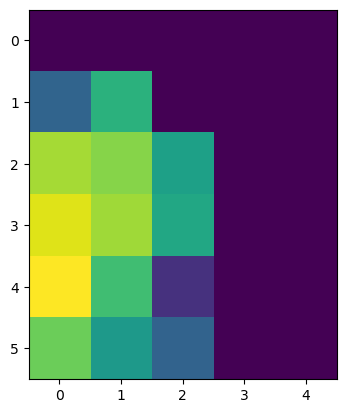

In [45]:
plt.imshow(X.squeeze())

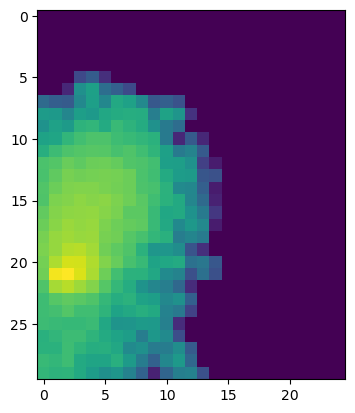

In [44]:
plt.imshow(y.squeeze())

In [ ]:
pos = []
i = 0
for row in range(6): 
    for col in range(5):
        conc = X[row][col]
        x_pos = col*5 + 2
        y_pos = (6-row)*5 - 2

        obs = Observation(position=(x_pos,y_pos), gas=conc) # adjust the y axis
        g_c.addObservation(obs)
g_c.estimate()

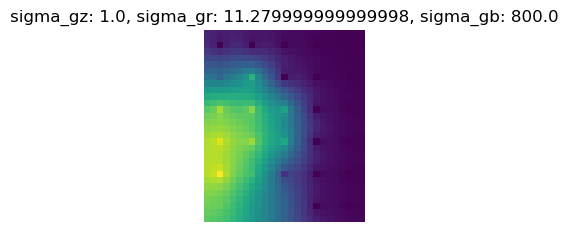

In [9]:
import matplotlib.pyplot as plt

DEFAULT_RES = 0.1
k = 0.8 # Correct for variance scale
gz = 0.1 / DEFAULT_RES
gr = 1.128 / DEFAULT_RES # Compensated for resolution
gb = k * 1000
DEFAULT_GTK = 0.012

gmrf = myGMRF(sigma_gz=gz, sigma_gr=gr, sigma_gb=gb, gtk=DEFAULT_GTK, resolution=1)
y_gmrf = gmrf.calculate(X.squeeze())[None,None,:]
plt.figure(figsize=(3, 2.5))
plt.imshow(y_gmrf.squeeze())
plt.axis('off');
plt.title(f"sigma_gz: {gz}, sigma_gr: {gr}, sigma_gb: {gb}")
plt.show();

### Hyperparameter Tuning

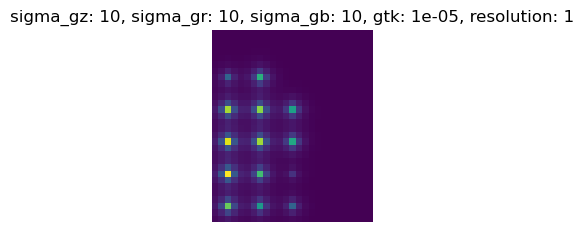

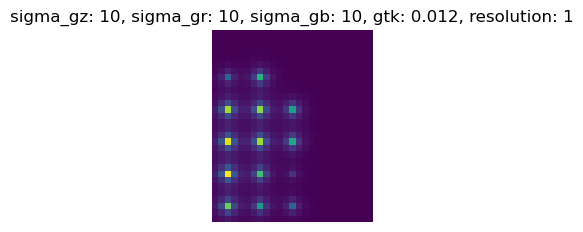

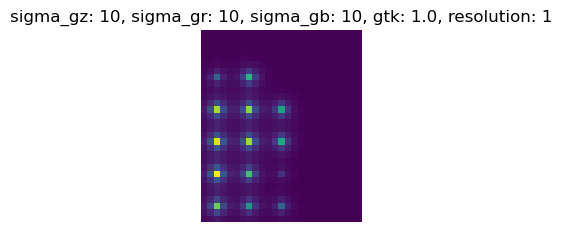

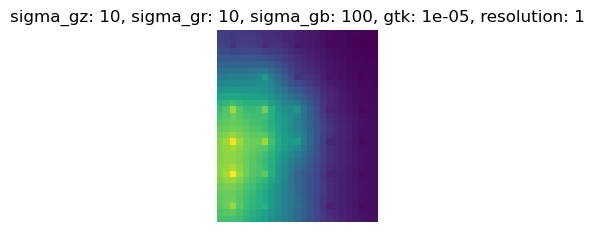

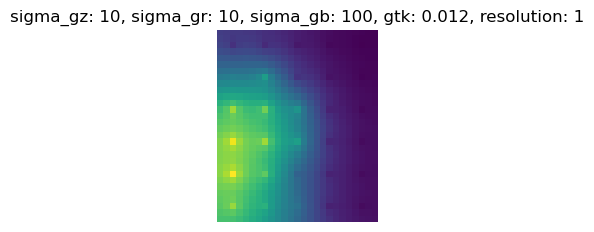

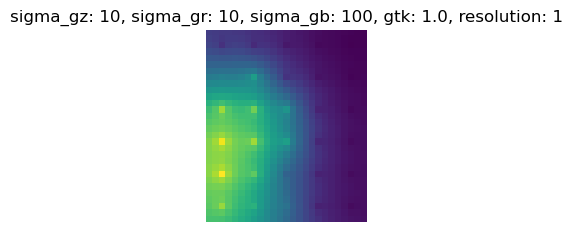

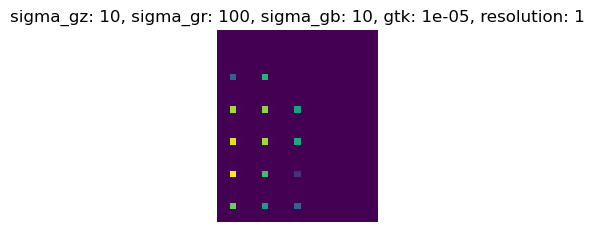

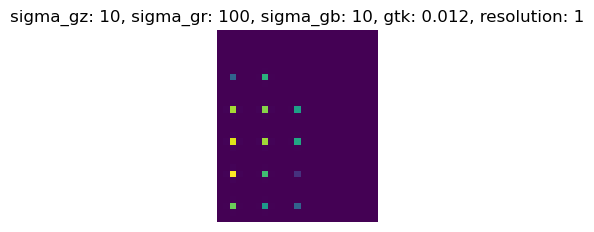

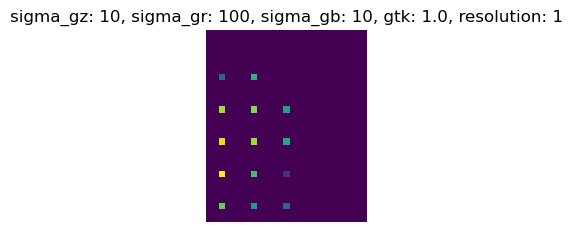

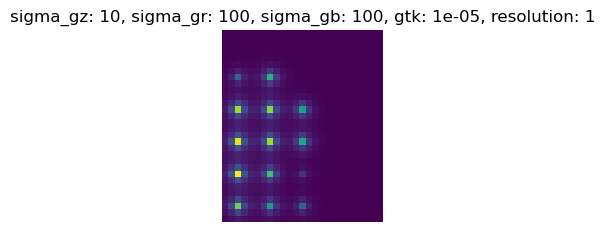

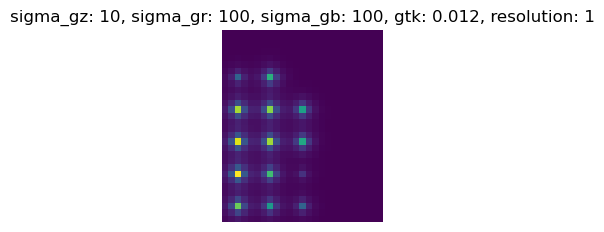

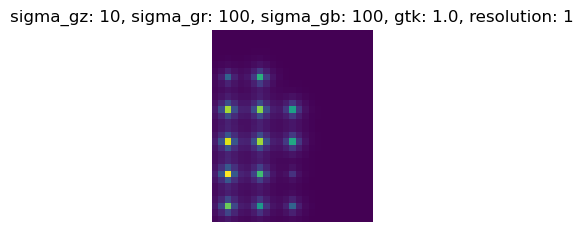

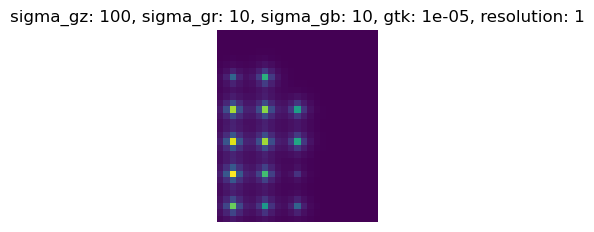

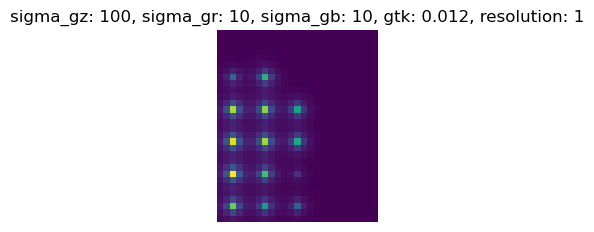

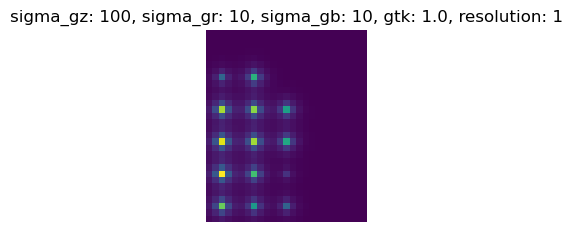

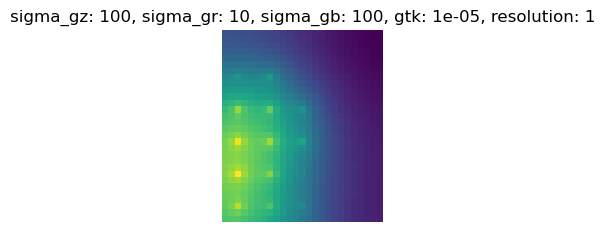

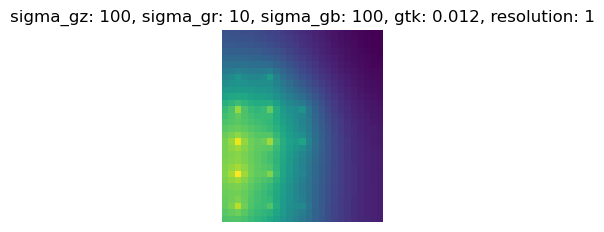

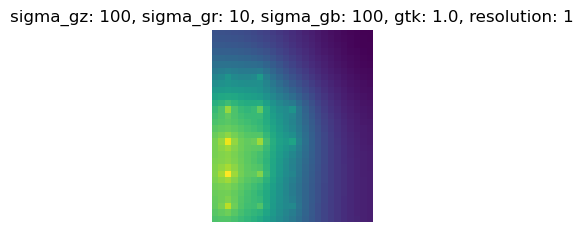

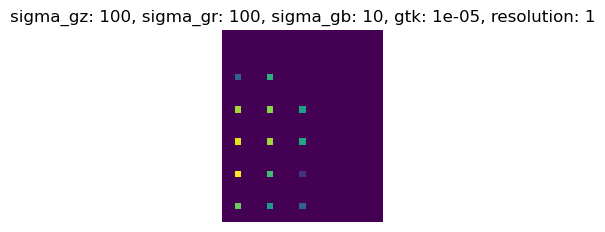

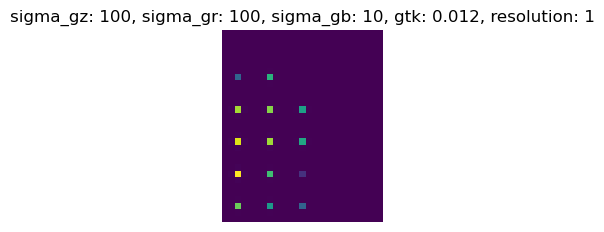

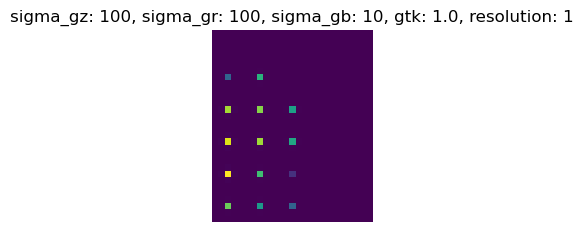

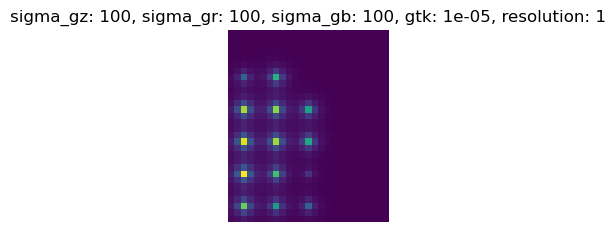

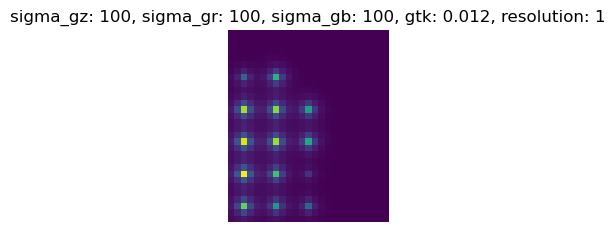

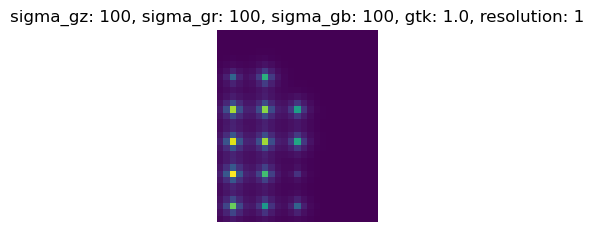

In [14]:
import matplotlib.pyplot as plt

l_sigma_gz = [10, 100]
l_sigma_gr = [10, 100]
l_sigma_gb = [10, 100]
l_gtk = [0.00001, 0.012, 1.0]
l_resolution = [1]

for gz in l_sigma_gz:
    for gr in l_sigma_gr:
        for gb in l_sigma_gb:
            for gtk in l_gtk:
                for resolution in l_resolution:
                    gmrf = myGMRF(sigma_gz=gz, sigma_gr=gr, sigma_gb=gb, gtk=gtk, resolution=resolution)
                    y_gmrf = gmrf.calculate(X.squeeze())[None,None,:]
                    plt.figure(figsize=(3, 2.5))
                    plt.imshow(y_gmrf.squeeze())
                    plt.axis('off');
                    plt.title(f"sigma_gz: {gz}, sigma_gr: {gr}, sigma_gb: {gb}, gtk: {gtk}, resolution: {resolution}")
                    plt.show();
